# Budget allocation proposal

This notebook holds the data analysis and text for the budget allocation problem, exemplifying a few concepts as well as doing basic analysis of invested cost and yielded sessions & revenue.

In [1]:
import pandas as pd
import numpy as np
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 5]

validDf = pd.read_csv("../data/valid_dataset_minimal.csv")
campaigns = validDf["Campaign"].unique()
validDf["Date"] = pd.to_datetime(validDf["Date"])
validDf = validDf.drop(columns=["Unnamed: 0"])
print(validDf.replace("1000557 | GA | US | en | Hybrid | GDN Remarketing", "Remarketing").head(10))

        Date   Cost  Revenue Medium          Campaign  Sessions
0 2018-02-26   8.47     0.00    cpc  AW - Accessories        38
1 2018-02-26   0.68     0.00    cpc  AW - Accessories        13
2 2018-02-26   0.01     0.00    cpc  AW - Accessories         1
3 2018-02-26   0.22     0.00    cpc      AW - Apparel         1
4 2018-02-26  77.49     0.00    cpc       Remarketing        24
5 2018-02-26  17.89     0.00    cpc       Remarketing        25
6 2018-02-26   2.94     0.00    cpc       Remarketing         5
7 2018-02-27  12.14    96.94    cpc  AW - Accessories        48
8 2018-02-27   0.93     0.00    cpc  AW - Accessories        22
9 2018-02-27   1.09     0.00    cpc  AW - Accessories         2


Remove the entries for all campaigns that have no upcoming Revenue, as these are impossible to predict.

In [2]:
tmpDf = validDf.copy()
b4 = tmpDf.shape
for campaign in validDf["Campaign"].unique():
    df = validDf.loc[validDf["Campaign"] == campaign].reset_index()
    lastValidIndex = df.loc[df["Revenue"] > 0, "Revenue"].index.to_numpy()[-1]
    badIndices = df.loc[df.index > lastValidIndex, "index"].to_numpy()
    b4 = tmpDf.shape
    tmpDf = tmpDf.drop(badIndices)
validDf = tmpDf.reset_index(drop=True)
print("Before: %s. After removing useless cost entries: %s" % (str(b4), str(tmpDf.shape)))

Before: (9653, 6). After removing useless cost entries: (9651, 6)


## 1. Recap

Let's start with a plot from the first notebook, where, for each valid campaign, I plot the daily cost, number of sessions and revenue.

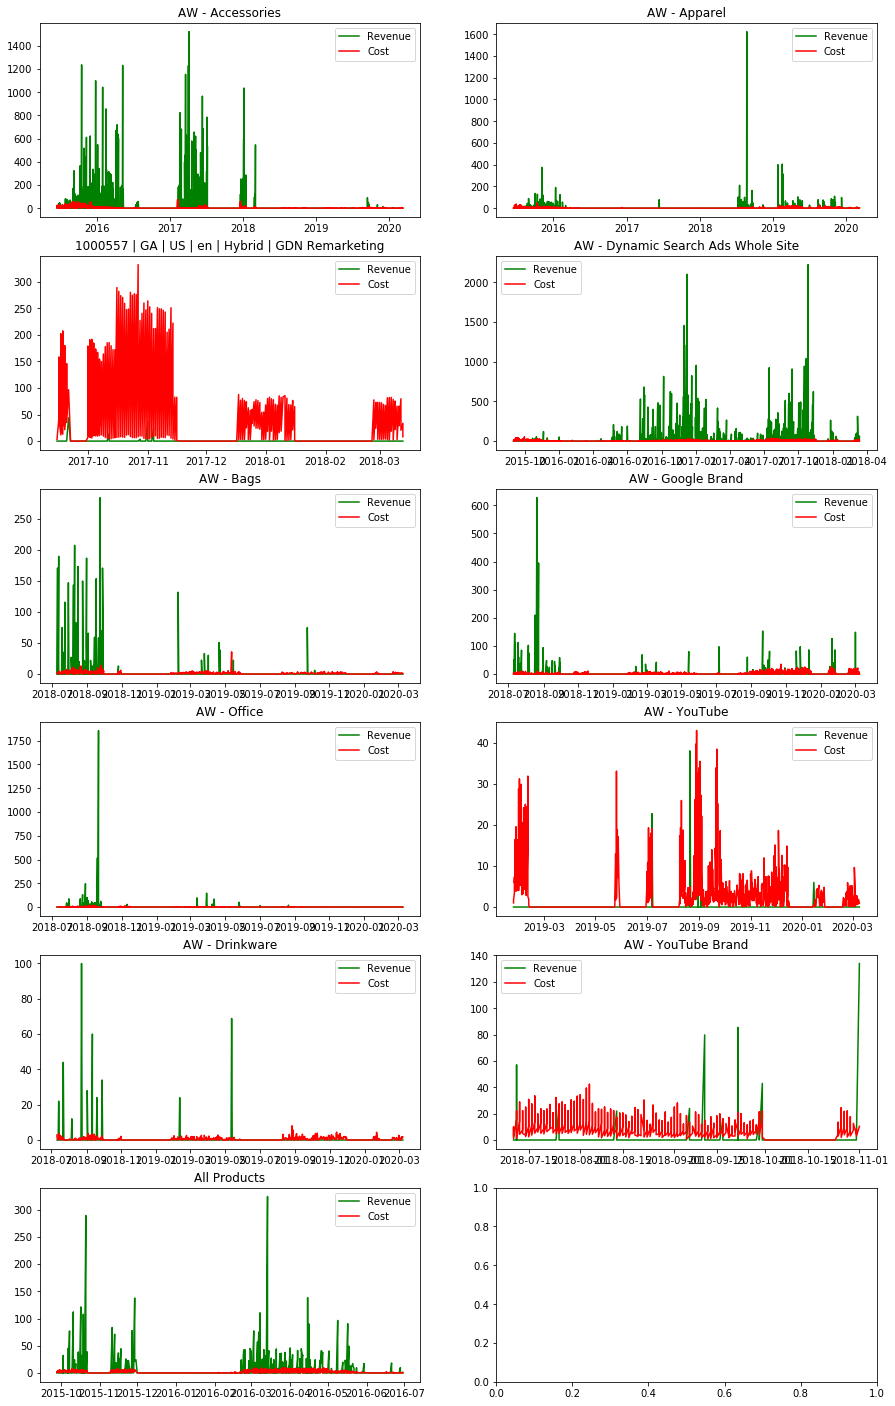

In [3]:
# Do a list of all dates between earliest and latest
nRows = len(campaigns)
ax = plt.subplots(nRows // 2 + 1, 2, figsize=(15, 25))[1]

for i, campaign in enumerate(campaigns):
    dfRelevant = validDf[validDf["Campaign"] == campaign]
    dateRange = pd.DataFrame({
        "Date" : pd.date_range(dfRelevant["Date"].min(), dfRelevant["Date"].max(), freq="D"),
    })
    # Fill missing months by zeros
    dfRelevant = dateRange.set_index("Date").join(dfRelevant.set_index("Date")).fillna(0).reset_index()

    ax[i//2, i%2].plot(dfRelevant["Date"], dfRelevant["Revenue"], color="green")
    ax[i//2, i%2].plot(dfRelevant["Date"], dfRelevant["Cost"], color="red")
    ax[i//2, i%2].set_title(campaign)
    ax[i//2, i%2].legend(["Revenue", "Cost"])

We see that, each campaign has some investment, and then that investment yields some user sessions and some revenue. However, we have no idea what investment is correlated to what change in revenue. The data only tells us daily information: how much we invested today

## 2. First-revenue assumption

### 2.1 Dataset creation

We'll create buckets of:
 - costs: [[c11, c12, c13], [c21, 22], ..., [cN1, cNk]]
 - revenues: [[r11, r12], [r21], [r31], ..., [rN1, rNk]]

where each item in the list represents the first N costs and it's afferent revenue. There can be multiple revenues just in the case where there are consecutive revenue with no costs inbetween (rare case, doesn't happen below).

In [4]:
def getDataFirstRevenue(df, campaign):
    df = df.loc[df["Campaign"] == campaign].reset_index()[["Date", "Cost", "Revenue"]]
    tmpRevenues = df.loc[df["Revenue"] > 0, "Revenue"]
    indexesL, indexesR = np.array([-1, *tmpRevenues.index[0 : -1]]), tmpRevenues.index.to_numpy()
    nRows = len(indexesL)

    costs, revenues, tmpRevenue = [], [], []
    for i in range(nRows):
        tmpRevenue.append(tmpRevenues.iloc[i])
        indexLeft, indexRight = indexesL[i], indexesR[i]
        items = df.loc[(df.index > indexLeft) & (df.index <= indexRight), "Cost"]

        # Consecutive revenues may also have cost of 0 between them, so we skip those and sum the revenues
        if items.sum() > 0:
            costs.append(items.to_numpy())
            revenues.append(tmpRevenue)
            tmpRevenue = []

    # If this fails, it means we got leftover costs with no upcoming revenue, which should've been eliminated above
    items = df.loc[df.index > indexesR[-1], ["Cost", "Revenue"]]
    assert len(items) == 0
    return np.array(costs), np.array(revenues)

X, t = {}, {}
for campaign in campaigns:
    costs, revenues = getDataFirstRevenue(validDf, campaign)
    if len(costs) < 20:
        continue
    X[campaign] = costs
    t[campaign] = revenues
    print("Campaign: %s. Shapes: %s %s" % (campaign, X[campaign].shape, t[campaign].shape), X[campaign].dtype, t[campaign].dtype)

Campaign: AW - Accessories. Shapes: (452,) (452, 1) object float64
Campaign: AW - Apparel. Shapes: (138,) (138, 1) object float64
Campaign: AW - Dynamic Search Ads Whole Site. Shapes: (382,) (382, 1) object float64
Campaign: AW - Bags. Shapes: (52,) (52, 1) object float64
Campaign: AW - Google Brand. Shapes: (56,) (56, 1) object float64
Campaign: AW - Office. Shapes: (36,) (36, 1) object float64
Campaign: All Products. Shapes: (109,) (109, 1) object float64


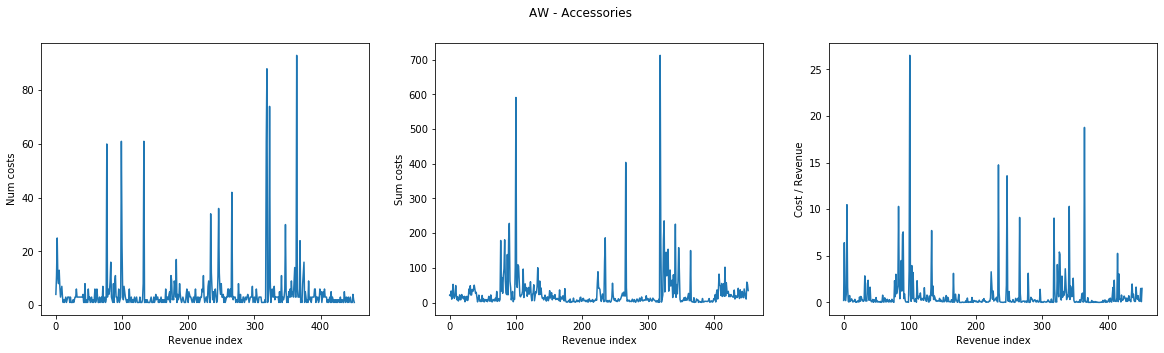

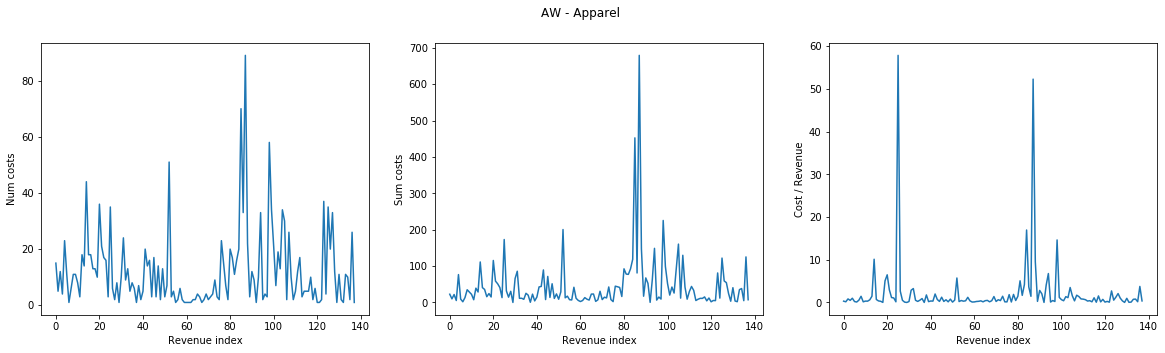

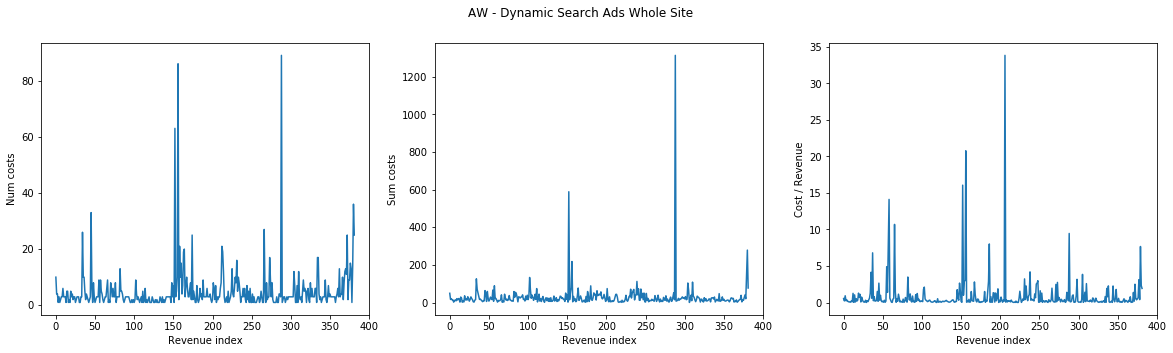

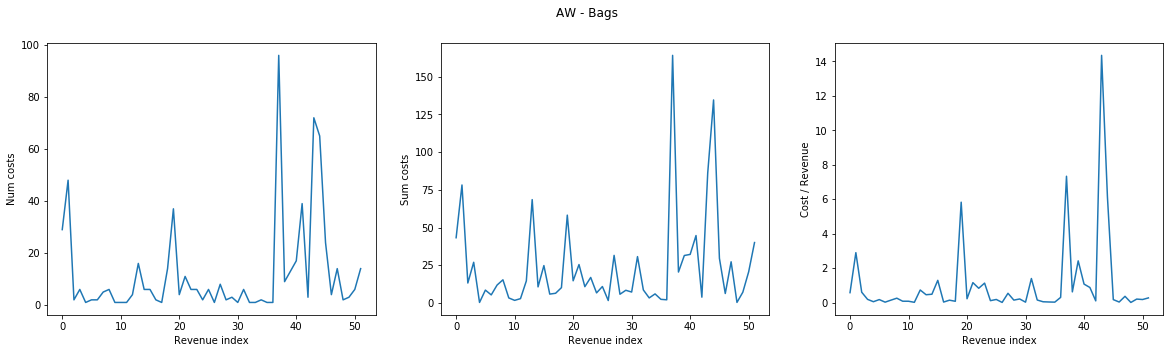

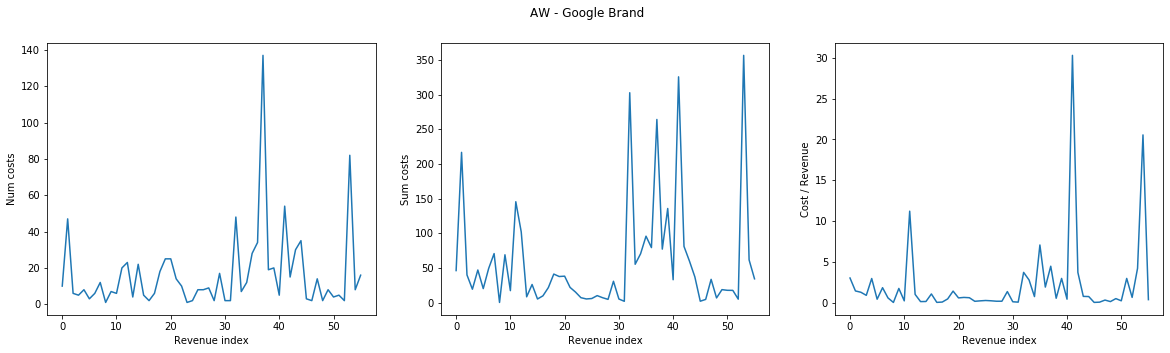

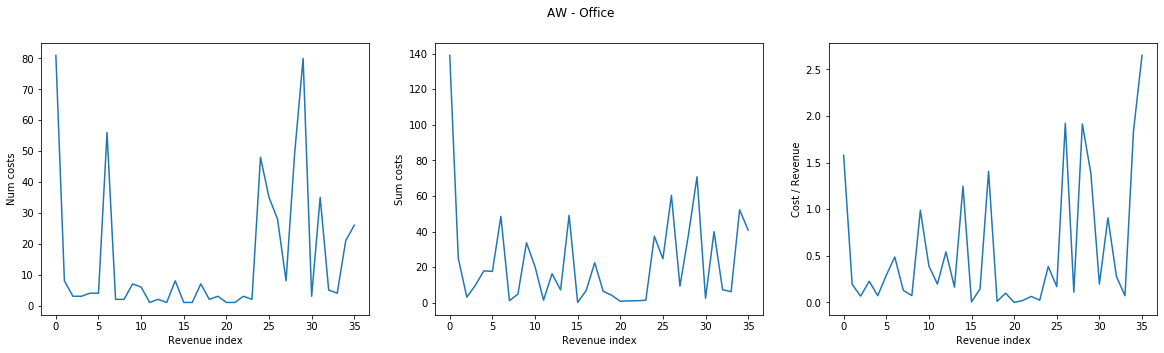

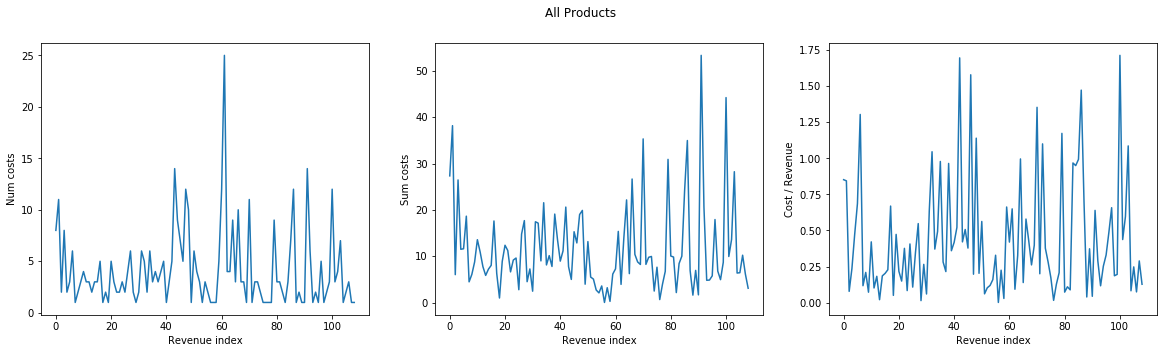

In [5]:
for campaign in X.keys():
    costs, revenues = X[campaign], t[campaign]
    numCosts = np.array([len(x) for x in costs])
    sumCosts = np.array([sum(x) for x in costs])
    rapp = np.array([sum(x) / sum(y) for x, y in zip(costs, revenues)])
    ax = plt.subplots(1, 3, figsize=(20, 5))[1]
    
    ax[0].plot(range(len(numCosts)), numCosts)
    ax[0].set_xlabel("Revenue index")
    ax[0].set_ylabel("Num costs")

    ax[1].plot(range(len(numCosts)), sumCosts)
    ax[1].set_xlabel("Revenue index")
    ax[1].set_ylabel("Sum costs")

    ax[2].plot(range(len(rapp)), rapp)
    ax[2].set_xlabel("Revenue index")
    ax[2].set_ylabel("Cost / Revenue")
    
    plt.gcf().suptitle(campaign)

#### 2.1.2 However, we only use the sum of the intermitent inner lists in the first-revenue assumption


In [6]:
XStatistical = {k : np.expand_dims(np.array([x.sum() for x in X[k]]), axis=-1) for k in X}
tStatistical = {k : np.expand_dims(np.array([x.sum() for x in t[k]]), axis=-1) for k in t}

for k in XStatistical:
    print(k, XStatistical[k].shape, tStatistical[k].shape)

AW - Accessories (452, 1) (452, 1)
AW - Apparel (138, 1) (138, 1)
AW - Dynamic Search Ads Whole Site (382, 1) (382, 1)
AW - Bags (52, 1) (52, 1)
AW - Google Brand (56, 1) (56, 1)
AW - Office (36, 1) (36, 1)
All Products (109, 1) (109, 1)


### 2.2 Statistical model (Notebook 2)

In [7]:
class StatisticalModel:
    def __init__(self):
        # This model has just a single parameter, computed as the count between targets and inputs
        self.param = np.nan
        
    def fit(self, x, t):
        assert self.param != self.param
        self.param = t.sum() / x.sum()
    
    def predict(self, x):
        assert self.param == self.param
        return x * self.param

class KFold:
    def __init__(self, numSplits, randomState):
        self.randomState = randomState
        assert numSplits > 0
        self.numSplits = numSplits
    
    def split(self, numData):
        np.random.seed(self.randomState)
        perm = np.random.permutation(numData)
        n = numData // self.numSplits
        for i in range(self.numSplits):
            trainIx = list(range(0, i * n)) + list(range((i + 1) * n, numData))
            valIx = list(range(i * n, (i + 1) * n))
            yield perm[trainIx], perm[valIx]

def errorL1(y, t):
    return np.abs(y - t).mean()

def trainModel(X, t, modelType, numSplits, randomState):
    kf = KFold(numSplits=numSplits, randomState=randomState)
    errors = []
    for trainIx, validationIx in kf.split(len(X)):
        model = modelType()
        model.fit(X[trainIx], t[trainIx])
        y = model.predict(X[validationIx])
        errors.append(errorL1(y, t[validationIx]))

    # We report the mean error on all K-fold splits for robustness
    meanError = np.mean(errors)
    
    # Then, we retrain on all data, for best test/future predictions
    model = modelType()
    model.fit(X, t)
    return model, meanError

def trainAllCampaigns(X, t, modelType, numSplits, randomState):
    models, errors = {}, {}
    validCampaigns = list(X.keys())
    for i, campaign in enumerate(validCampaigns):
        model, error = trainModel(X[campaign], t[campaign], modelType, numSplits, randomState)
        models[campaign] = model
        errors[campaign] = error
    return models, errors

### 2.2.1 Train the model on all campaigns

Note: The errors presented/returned here are model-dependendent and should not be used to classify between different ones. 

In [8]:
# Store the model for each campaign
statisticalModels, statisticalErrors = \
    trainAllCampaigns(XStatistical, tStatistical, StatisticalModel, numSplits=5, randomState=42)
display(pd.DataFrame([(x, y) for x, y in zip(statisticalErrors.keys(), statisticalErrors.values())], \
                     columns=["Campaign", "Best error (L1)"]))

,Campaign,Best error (L1)
0,AW - Accessories,187.565658
1,AW - Apparel,79.693915
2,AW - Dynamic Search Ads Whole Site,175.758303
3,AW - Bags,89.477605
4,AW - Google Brand,88.018563
5,AW - Office,170.169278
6,All Products,35.613550


### 2.2.2 Create pseudo-revenues for all costs

Using the trained model, we will create a new column *Pseudo Revenue*, which represents the estimated daily revenue. $Pseudo Revenue = Model_c(Cost_d), for c \in Campaigns, d \in Days(c)$

In [9]:
from typing import Tuple, List

def createPseudoRevenues(models : List, df : pd.DataFrame) -> Tuple[pd.DataFrame, dict]:
    validCampaigns = models.keys()
    finalDf = pd.DataFrame(columns=df.columns)
    for i, campaign in enumerate(validCampaigns):
        dfCampaign = df[df["Campaign"] == campaign].reset_index(drop=True)
        dfCampaign["Pseudo Revenue"] = models[campaign].predict(np.expand_dims(dfCampaign["Cost"], axis=-1))
        finalDf = pd.concat([finalDf, dfCampaign], sort=False)
    return finalDf.reset_index(drop=True)

In [10]:
statisticalModelDf = createPseudoRevenues(statisticalModels, validDf)
print(statisticalModelDf.shape, statisticalModelDf.columns)

(8281, 7) Index(['Date', 'Cost', 'Revenue', 'Medium', 'Campaign', 'Sessions',
       'Pseudo Revenue'],
      dtype='object')


#### 2.2.2.2 Plot Cost vs Pseudo Revenue

In [11]:
def plotRevenues(df):
    validCampaigns = df["Campaign"].unique()
    ax = plt.subplots(len(validCampaigns) // 2 + 1, 2, figsize=(15, 15))[1]
    for i, campaign in enumerate(validCampaigns):
        campaignDf = df[df["Campaign"] == campaign]
        dateRange = pd.DataFrame({
            "Date" : pd.date_range(campaignDf["Date"].min(), campaignDf["Date"].max(), freq="D"),
        })
        # Fill missing months by zeros
        campaignDf = dateRange.set_index("Date").join(campaignDf.set_index("Date")).fillna(0).reset_index()
        campaignDf = campaignDf[campaignDf["Cost"] > 0]

        ax[i//2, i%2].scatter(campaignDf["Date"], campaignDf["Pseudo Revenue"], color="green")
        ax[i//2, i%2].scatter(campaignDf["Date"], campaignDf["Cost"], color="red")
        ax[i//2, i%2].set_title(campaign)
        ax[i//2, i%2].legend(["Pseudo Revenue", "Cost"])

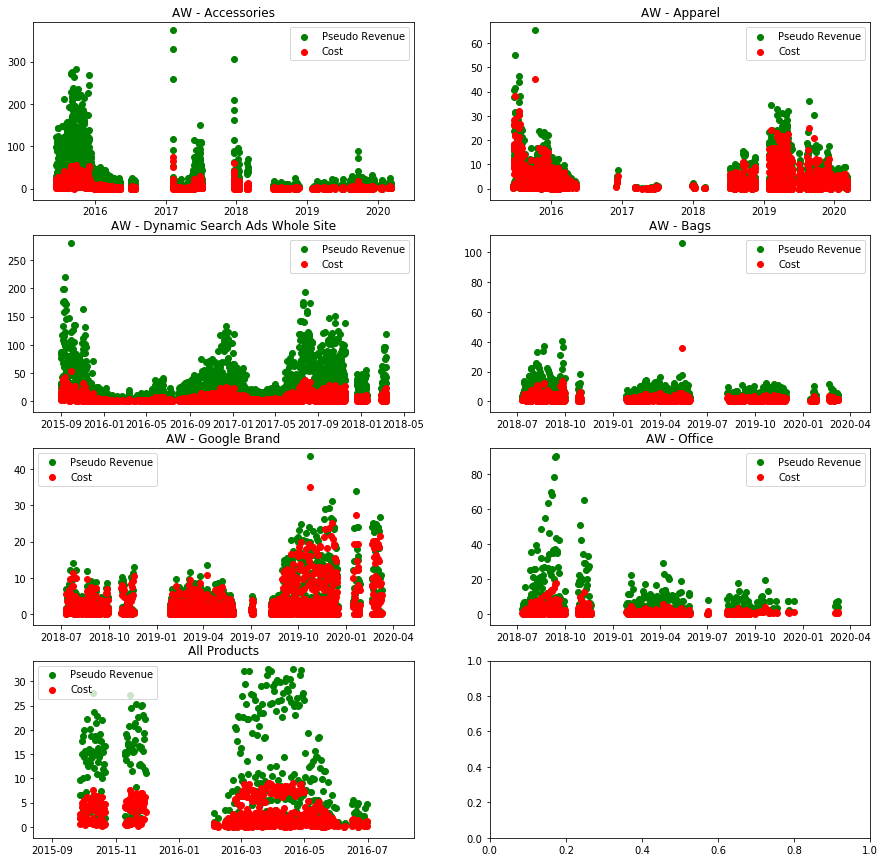

In [12]:
plotRevenues(statisticalModelDf)

#### 2.2.2.3 Scatter Cost vs Pseudo Revenue

In [13]:
def scatterRevenues(df):
    validCampaigns = df["Campaign"].unique()
    ax = plt.subplots(len(validCampaigns) // 2 + 1, 2, figsize=(15, 15))[1]
    for i, campaign in enumerate(validCampaigns):
        campaignDf = df[df["Campaign"] == campaign]
        costs = campaignDf["Cost"].to_numpy()
        pseudoRevenues = campaignDf["Pseudo Revenue"].to_numpy()
        
        argSort = np.argsort(costs)
        costs = costs[argSort]
        pseudoRevenues = pseudoRevenues[argSort]
        X = range(len(pseudoRevenues))

        ax[i//2, i%2].scatter(X, costs, color="green")
        ax[i//2, i%2].scatter(X, pseudoRevenues, color="red")
        ax[i//2, i%2].set_title(campaign)
        ax[i//2, i%2].legend(["Costs", "Pseudo Revenues"])

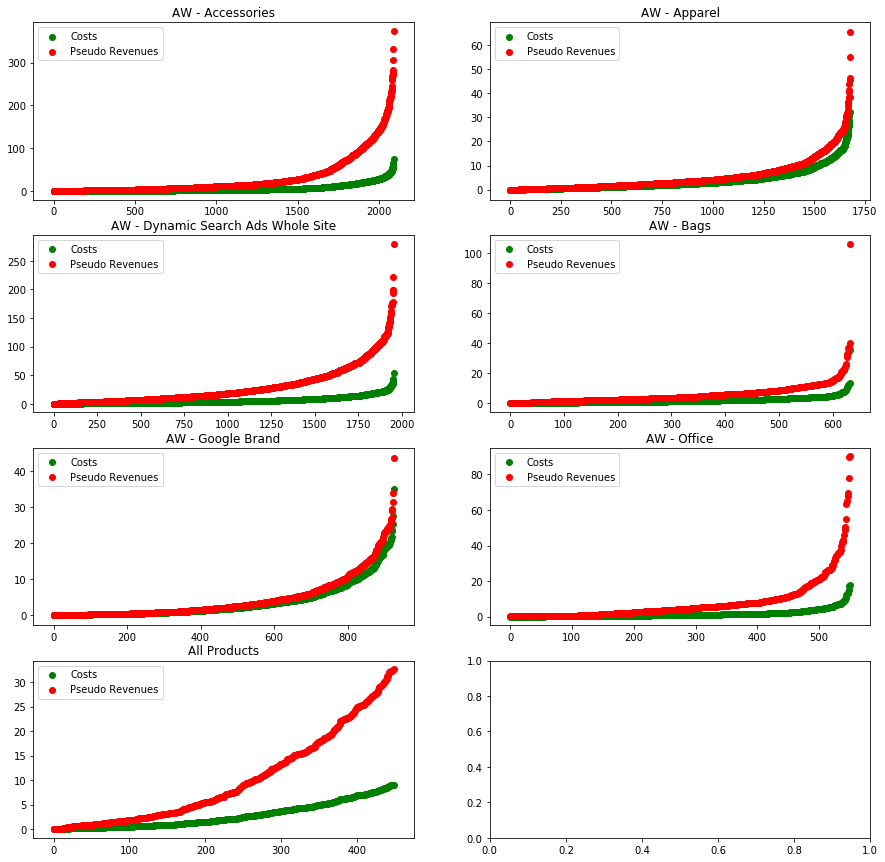

In [14]:
scatterRevenues(statisticalModelDf)

### 2.2.3 Create the Summed Pseudo Revenues column

We create a new column that will be the sum of pseudo revenues for all our available revenues. This is the opposite of the data split, where we got our $(C, R)$, $C_{R_i} = \sum_{j}C_j, j \in$ indices between $R(i)$ and $R(i+1)$ for all $R$

In [15]:
def getSummedPseudoRevenues(finalDf):
    campaigns = finalDf["Campaign"].unique()
    finalDf["Summed Pseudo Revenue"] = 0
    for i, campaign in enumerate(campaigns):
        ix = 0

        costs = getDataFirstRevenue(finalDf.copy(), campaign)[0]
        flattenedIndices = []
        pseudoRevenues = finalDf.loc[finalDf["Campaign"] == campaign, "Pseudo Revenue"]
        originalIndex = np.where(finalDf["Campaign"] == campaign)[0]

        for i in range(len(costs)):
            rIx = ix + len(costs[i])
            thisPseudos = pseudoRevenues[ix : rIx]
            # Sanity check that there aren't null revenues
            assert finalDf.iloc[originalIndex[rIx -1]]["Revenue"] > 0
            finalDf.loc[originalIndex[rIx -1], "Summed Pseudo Revenue"] = thisPseudos.sum()
            ix = rIx
        assert ix == len(pseudoRevenues), (ix, len(pseudoRevenues))
    # Final sanity check: See that all our revenue positions have now been filled with summed pseudo revenues
    assert (finalDf.loc[finalDf["Revenue"] > 0, ["Revenue", "Summed Pseudo Revenue"]] == 0).to_numpy().sum() == 0
    return finalDf

In [16]:
statisticalModelDf = getSummedPseudoRevenues(statisticalModelDf)
print(statisticalModelDf.shape, statisticalModelDf.columns)

(8281, 8) Index(['Date', 'Cost', 'Revenue', 'Medium', 'Campaign', 'Sessions',
       'Pseudo Revenue', 'Summed Pseudo Revenue'],
      dtype='object')


#### 2.2.3.2 Plot Summed Revenue vs Summed Pseudo Revenue

The errors and plots presented here and below are to be used against other models

In [17]:
def plotSummedRevenues(df):
    validCampaigns = df["Campaign"].unique()
    ax = plt.subplots(len(validCampaigns) // 2 + 1, 2, figsize=(15, 15))[1]
    for i, campaign in enumerate(validCampaigns):
        campaignDf = df[df["Campaign"] == campaign]
        dateRange = pd.DataFrame({
            "Date" : pd.date_range(campaignDf["Date"].min(), campaignDf["Date"].max(), freq="D"),
        })
        # Fill missing months by zeros
        campaignDf = dateRange.set_index("Date").join(campaignDf.set_index("Date")).fillna(0).reset_index()

        ax[i//2, i%2].plot(campaignDf["Date"], campaignDf["Summed Pseudo Revenue"], color="green")
        ax[i//2, i%2].plot(campaignDf["Date"], campaignDf["Revenue"], color="red")
        ax[i//2, i%2].set_title(campaign)
        ax[i//2, i%2].legend(["Summed Pseudo Revenue", "Pseudo Revenue"])

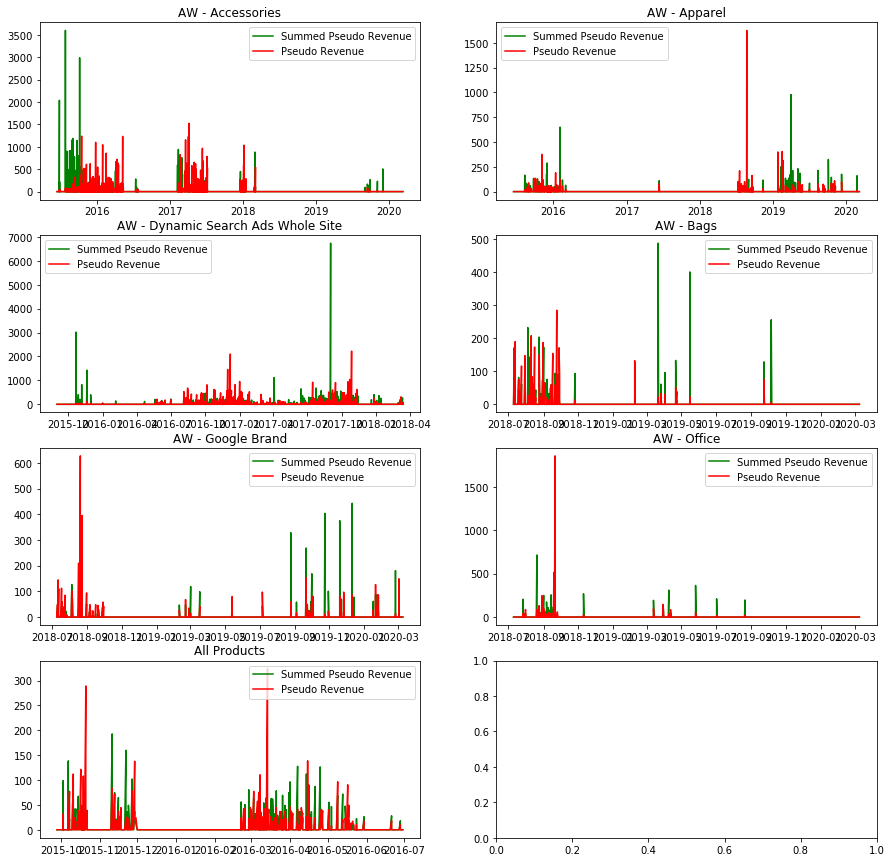

In [18]:
plotSummedRevenues(statisticalModelDf)

#### 2.2.3.3 Plot Summed Revenue vs Summed Pseudo Revenue

In [19]:
def scatterSummedRevenues(df):
    validCampaigns = df["Campaign"].unique()
    ax = plt.subplots(len(validCampaigns) // 2 + 1, 2, figsize=(15, 15))[1]
    for i, campaign in enumerate(validCampaigns):
        campaignDf = df[df["Campaign"] == campaign]
        dateRange = pd.DataFrame({
            "Date" : pd.date_range(campaignDf["Date"].min(), campaignDf["Date"].max(), freq="D"),
        })
        # Fill missing months by zeros
        campaignDf = dateRange.set_index("Date").join(campaignDf.set_index("Date")).fillna(0).reset_index()
        
        campaignDf = campaignDf[campaignDf["Revenue"] > 0]
        revenues = campaignDf["Revenue"].to_numpy()
        summedPseudoRevenues = campaignDf["Summed Pseudo Revenue"].to_numpy()
        
#         argSort = np.argsort(revenues)
#         revenues = revenues[argSort]
#         summedPseudoRevenues = summedPseudoRevenues[argSort]
#         X = range(len(revenues))

        ax[i//2, i%2].scatter(campaignDf["Date"], revenues, color="green")
        ax[i//2, i%2].scatter(campaignDf["Date"], summedPseudoRevenues, color="red")
        ax[i//2, i%2].set_title(campaign)
        ax[i//2, i%2].legend(["Revenues", "Summed Pseudo Revenues"])

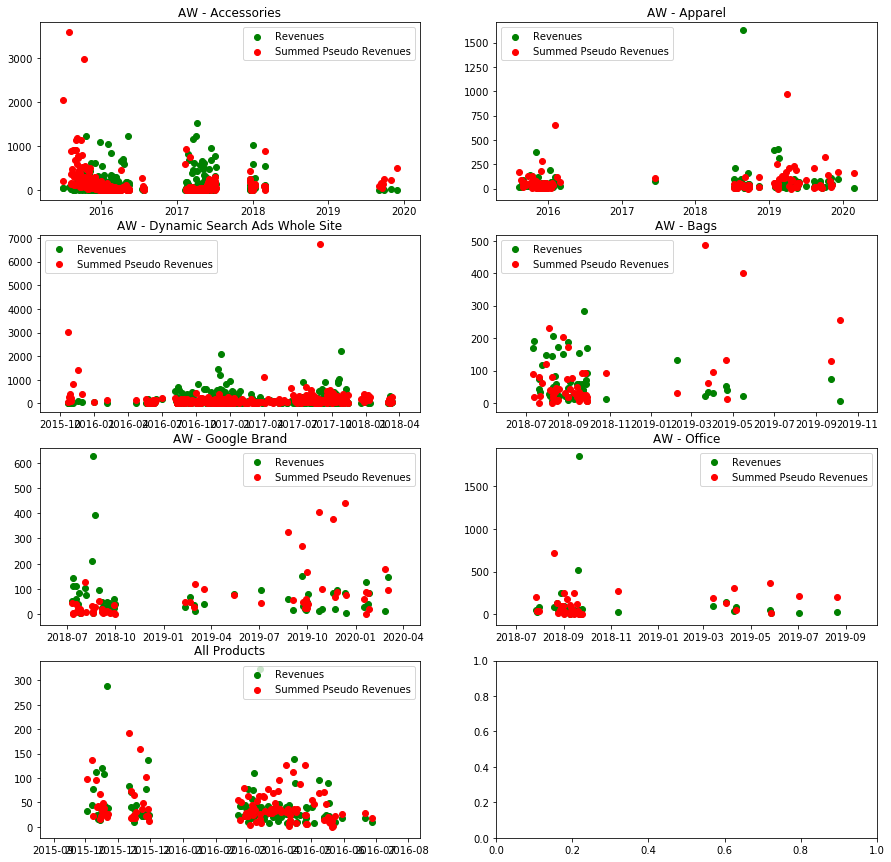

In [20]:
scatterSummedRevenues(statisticalModelDf)

#### 2.2.3.4 Plot |Summed Revenue - Summed Pseudo Revenue| (L1 error)

In [42]:
def scatterErrorSummedRevenues(df):
    validCampaigns = df["Campaign"].unique()
    ax = plt.subplots(len(validCampaigns) // 2 + 1, 2, figsize=(15, 15))[1]
    for i, campaign in enumerate(validCampaigns):
        campaignDf = df[df["Campaign"] == campaign]
        dateRange = pd.DataFrame({
            "Date" : pd.date_range(campaignDf["Date"].min(), campaignDf["Date"].max(), freq="D"),
        })
        # Fill missing months by zeros
        campaignDf = dateRange.set_index("Date").join(campaignDf.set_index("Date")).fillna(0).reset_index()
        
        campaignDf = campaignDf[campaignDf["Revenue"] > 0]
        diffs = (campaignDf["Revenue"] - campaignDf["Summed Pseudo Revenue"]).abs().to_numpy()
         
#         Mins = np.minimum(campaignDf["Summed Pseudo Revenue"], campaignDf["Revenue"])
#         Maxs = np.maximum(campaignDf["Summed Pseudo Revenue"], campaignDf["Revenue"])
#         relative = 1 - (Mins / Maxs)
  
        ax[i//2, i%2].scatter(campaignDf["Date"], diffs)
#         ax[i//2, i%2].scatter(campaignDf["Date"], diffs, color="green")
        ax[i//2, i%2].plot(campaignDf["Date"], [diffs.mean()] * len(campaignDf))
        ax[i//2, i%2].set_title(campaign)
        ax[i//2, i%2].legend(["|Revenues - Summed Pseudo Revenues|\nMean: %2.3f" % (diffs.mean())])

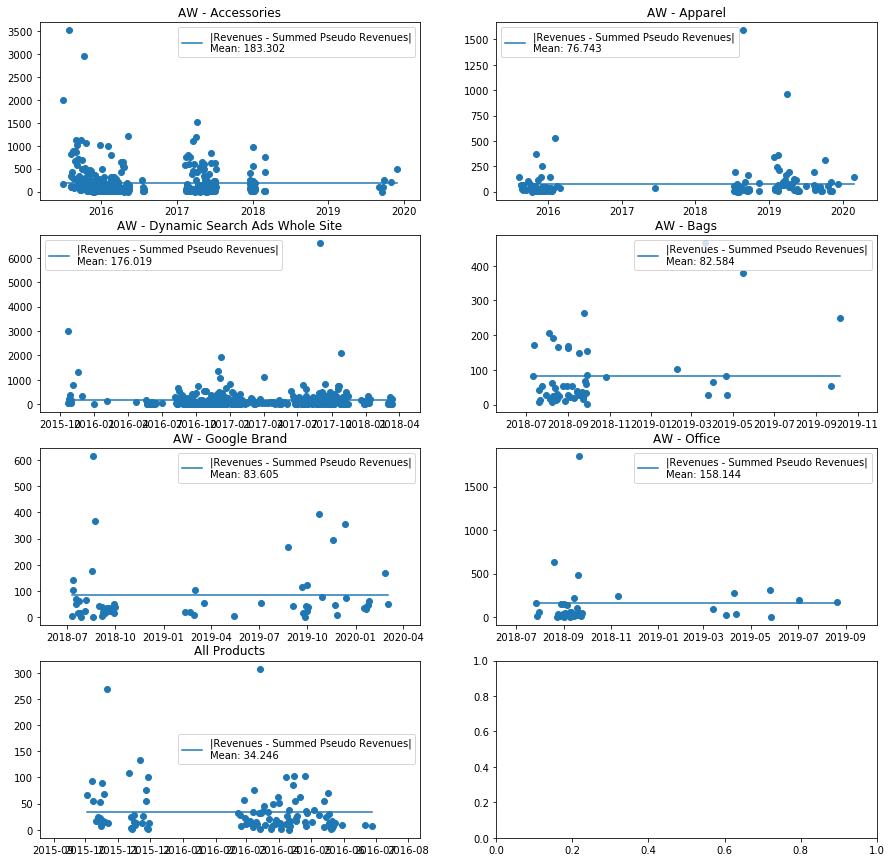

In [44]:
scatterErrorSummedRevenues(statisticalModelDf)

### 2.2.4 Print the model's error

This is computed as: $mean(|Summed Pseudo Revenues - Revenues|)$ for each campaign independently 

In [97]:
def f(x):
    whereOk = x["Revenue"] > 0
    spr = x["Summed Pseudo Revenue"][whereOk]
    revs = x["Revenue"][whereOk]
    Mins = np.minimum(spr, revs)
    Maxs = np.maximum(spr, revs)
    return (1 - Mins / Maxs).mean()

def getOverallError(df):
    def avgDiff(x):
        Mean = (x["Summed Pseudo Revenue"] - x["Revenue"]).abs().mean()
        Std = (x["Summed Pseudo Revenue"] - x["Revenue"]).abs().std()
        return "%2.3f +/- %2.3f" % (Mean, Std)

    def avgRelative(x):
        avgDiff = (x["Summed Pseudo Revenue"] - x["Revenue"]).abs().mean()
        avgRevenue = x["Revenue"].mean()
        return 100 * (avgDiff / (avgDiff + avgRevenue))

    return df[df["Revenue"] > 0].groupby("Campaign").apply(lambda x : pd.Series({
        "Sum Revenues" : x["Revenue"].sum(),
        "Sum Pseudo Revenues": x["Pseudo Revenue"].sum(),
        "Avg Revenue" : x["Revenue"].mean(),
        "Avg Diff Error (L1)": avgDiff(x),
        "Avg Relative (%)" : avgRelative(x)
    })).reset_index()

In [98]:
overallError = getOverallError(statisticalModelDf)
display(overallError)

,Campaign,Sum Revenues,Sum Pseudo Revenues,Avg Revenue,Avg Diff Error (L1),Avg Relative (%)
0,AW - Accessories,63700.71,24470.821981,140.930774,183.302 +/- 324.178,56.534047
1,AW - Apparel,9104.17,728.692341,65.972246,76.743 +/- 171.821,53.773511
2,AW - Bags,3721.28,487.186414,71.563077,82.584 +/- 94.826,53.574899
3,AW - Dynamic Search Ads Whole Site,57540.27,18434.964078,150.628979,176.019 +/- 431.510,53.886399
4,AW - Google Brand,4122.77,338.980830,73.620893,83.605 +/- 117.668,53.175134
5,AW - Office,4269.28,487.892719,118.591111,158.144 +/- 322.369,57.146387
6,All Products,4502.51,1674.212127,41.307431,34.246 +/- 45.258,45.326503


### 2.2.5 Plot Cost vs PseudoRevenue

In [80]:
def plotFinalResults(df, overallError):
    validCampaigns = df["Campaign"].unique()
    ax = plt.subplots(len(validCampaigns) // 2 + 1, 2, figsize=(15, 15))[1]
    for i, campaign in enumerate(validCampaigns):
        dfCampaign = df[df["Campaign"] == campaign]
        dateRange = pd.DataFrame({
            "Date" : pd.date_range(dfCampaign["Date"].min(), dfCampaign["Date"].max(), freq="D"),
        })
        # Fill missing months by zeros
        dfCampaign = dateRange.set_index("Date").join(dfCampaign.set_index("Date")).fillna(0).reset_index()

        ax[i//2, i%2].plot(dfCampaign["Date"], dfCampaign["Pseudo Revenue"])
        ax[i//2, i%2].plot(dfCampaign["Date"], dfCampaign["Cost"])
        ax[i//2, i%2].set_title("Campaign: %s." % (campaign))
        ax[i//2, i%2].legend(["Pseudo Revenue", "Cost"])

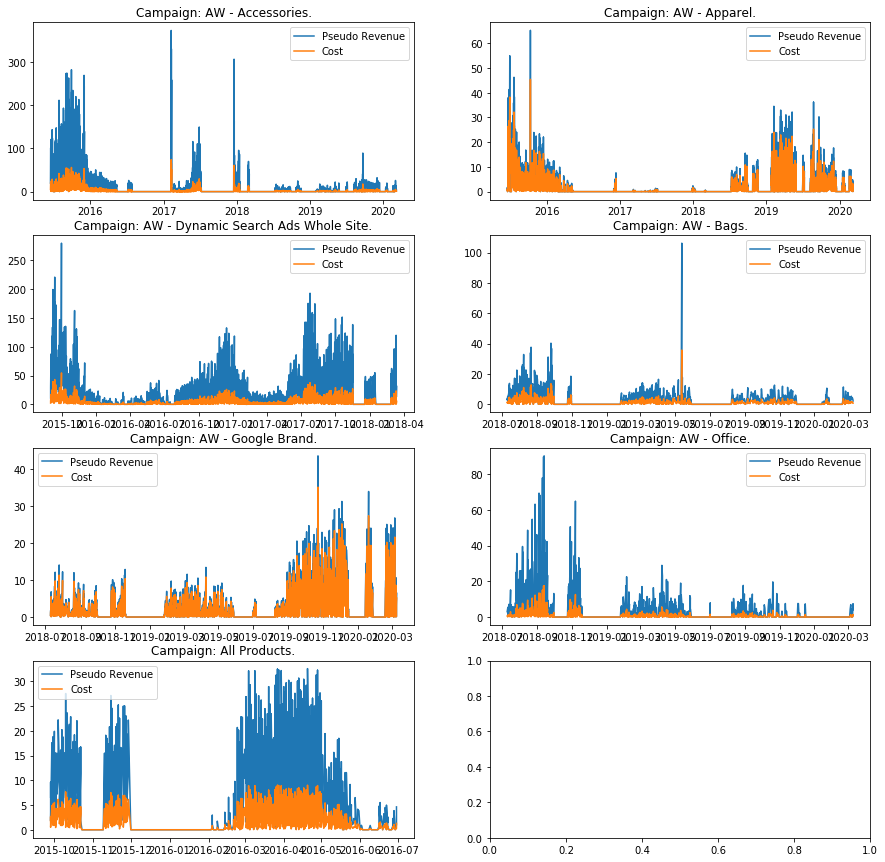

In [81]:
plotFinalResults(statisticalModelDf, overallError)

### 2.3 Linear Regression

For Linear Regression we've got the problem that the training data and the testing data is not from the same distribution.

Basically, the problem is that we are training on Data: $X=\sum(Costs)$ and Labels: $t=Revenue$, however, when we are using the model, we are generating from the distribution Data: $X=Cost$, PseudoRevenue: $y=f(X)$.

The problem can be the simplest explained as: $a * f(x_1 + x_2) + b != [a * f(x_1) + b] + [a * f(x_2) + b] $.

However, we can always pre-split our data in first-revenue assumption AND linear time assumption (see proposal), basically instead of having $X=\sum_n(Costs)$, $t=Revenue$, we can have $X=[Cost_1, ..., Cost_n]$, $t=[\frac{Revenue}{Cost_1}, ..., \frac{Revenue}{Cost_n}]$. 

If we were to not use a linear time assumption, we'd have a non-linear ponder $t=[\frac{Revenue}{Cost_1}*w_1, ..., \frac{Revenue}{Cost_n}*w_n]$, where $w_i$ is somehow dependant on time (separate model or such).

#### 2.3.1 Dataset creation

In [82]:
XLinearRegression, tLinearRegression, Mappings = {}, {}, {}

def getDataLR(X, t):
    Mappings, XRes, tRes = [], [], []
    N = len(X)
    for i in range(N):
        XRes.extend(list(X[i]))
        tRes.extend(list(t[i] / X[i]))
        Mappings.extend([i] * len(X[i]))
    return np.array(XRes).reshape((-1, 1)), np.array(tRes).reshape((-1, 1)), np.array(Mappings)
                                                                    
for k in X:
    XLinearRegression[k], tLinearRegression[k], Mappings[k] = getDataLR(X[k], t[k])
    print(k, XLinearRegression[k].shape, tLinearRegression[k].shape, Mappings[k].shape)

AW - Accessories (2090, 1) (2090, 1) (2090,)
AW - Apparel (1678, 1) (1678, 1) (1678,)
AW - Dynamic Search Ads Whole Site (1954, 1) (1954, 1) (1954,)
AW - Bags (633, 1) (633, 1) (633,)
AW - Google Brand (926, 1) (926, 1) (926,)
AW - Office (551, 1) (551, 1) (551,)
All Products (449, 1) (449, 1) (449,)


In [83]:
from sklearn.linear_model import LinearRegression
from functools import partial

def trainModelLR(X, t, Mappings, modelType, numSplits, randomState):
    kf = KFold(numSplits=numSplits, randomState=randomState)
    errors = []
    Max = Mappings.max()
    ix = np.arange(Max)
    for trainIx, validationIx in kf.split(Max):
        model = modelType()
        trainMap, valMap = ix[trainIx], ix[validationIx]
        whereTrain = np.isin(Mappings, trainMap)
        whereVal = np.isin(Mappings, valMap)
        model.fit(X[whereTrain], t[whereTrain])
        y = model.predict(X[whereVal])
        errors.append(errorL1(y, t[whereVal]))

    # We report the mean error on all K-fold splits for robustness
    meanError = np.mean(errors)
    
    # Then, we retrain on all data, for best test/future predictions
    model = modelType()
    model.fit(X, t)
    return model, meanError

def trainAllCampaignsLR(X, t, modelType, numSplits, randomState):
    models, errors = {}, {}
    validCampaigns = list(X.keys())
    XXs = {
        'AW - Accessories' : 99,
        'AW - Apparel' : 89,
        'AW - Dynamic Search Ads Whole Site' : 99,
        'AW - Bags' : 58,
        'AW - Google Brand' : 58,
        'AW - Office' : 46,
        'All Products' : 99,
    }
    # Optimize threshold for all campaigns to remove outliers.
#     for i, campaign in enumerate(validCampaigns):
#         res = []
#         for i in range(100):
#             thisT = np.clip(t[campaign], 0, np.percentile(t[campaign], i))
#             model, error = trainModelLR(X[campaign], thisT, Mappings[campaign], modelType, numSplits, randomState)
#             dfCampaign = validDf[validDf["Campaign"] == campaign].copy()
#             dfCampaign["Pseudo Revenue"] = model.predict(np.expand_dims(dfCampaign["Cost"], axis=-1))
#             error = np.abs(dfCampaign["Revenue"].sum() - dfCampaign["Pseudo Revenue"].sum())
#             res.append(error)
#         print(campaign, np.argmin(res))
    
    for i, campaign in enumerate(validCampaigns):
        thisT = np.clip(t[campaign], 0, np.percentile(t[campaign], XXs[campaign]))
#         thisT = np.clip(t[campaign], 0, 3 * np.median(t[campaign]))
        model, error = trainModelLR(X[campaign], thisT, Mappings[campaign], modelType, numSplits, randomState)
        dfCampaign = validDf[validDf["Campaign"] == campaign].copy()
        dfCampaign["Pseudo Revenue"] = model.predict(np.expand_dims(dfCampaign["Cost"], axis=-1))
        error = dfCampaign["Revenue"].sum() - dfCampaign["Pseudo Revenue"].sum()
        models[campaign] = model
        errors[campaign] = error
    return models, errors

LR = partial(LinearRegression, fit_intercept=False, normalize=True)
LRModels, LRErrors = trainAllCampaignsLR(XLinearRegression, tLinearRegression, LR, numSplits=5, randomState=42)
display(pd.DataFrame([(x, y) for x, y in zip(LRErrors.keys(), LRErrors.values())], columns=["Campaign", "Best error (L1)"]))
# LRFinalDf = createPseudoRevenues(LRModels, validDf)
# LROverallError = getOverallError(LRFinalDf)

,Campaign,Best error (L1)
0,AW - Accessories,51415.407245
1,AW - Apparel,62.739818
2,AW - Dynamic Search Ads Whole Site,37550.422273
3,AW - Bags,33.813005
4,AW - Google Brand,10.170680
5,AW - Office,-27.922767
6,All Products,966.978175


In [84]:
LRFinalDf = createPseudoRevenues(LRModels, validDf)
print(LRFinalDf.shape, LRFinalDf.columns)

(8281, 7) Index(['Date', 'Cost', 'Revenue', 'Medium', 'Campaign', 'Sessions',
       'Pseudo Revenue'],
      dtype='object')


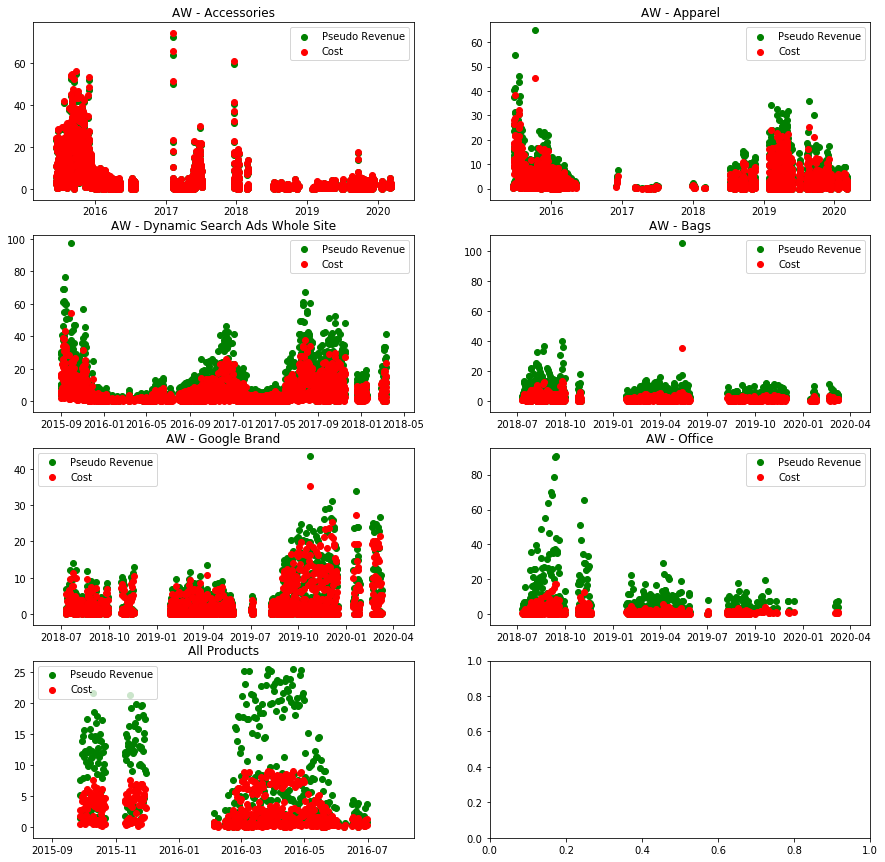

In [85]:
plotRevenues(LRFinalDf)

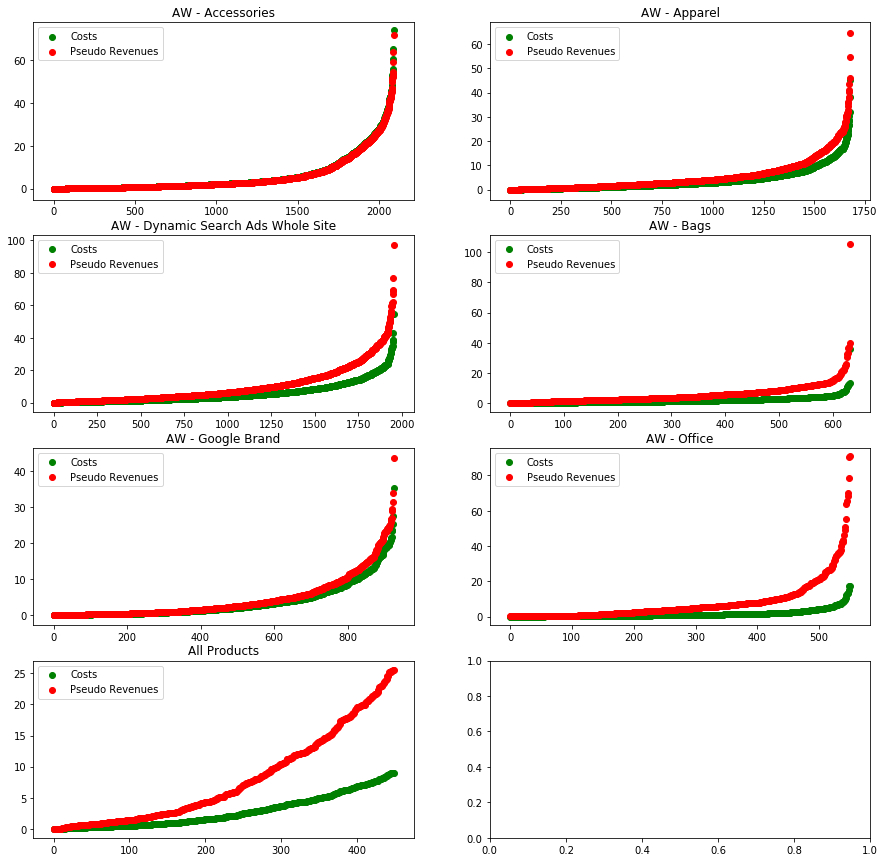

In [86]:
scatterRevenues(LRFinalDf)

In [87]:
LRFinalDf = getSummedPseudoRevenues(LRFinalDf)
print(LRFinalDf.shape, LRFinalDf.columns)

(8281, 8) Index(['Date', 'Cost', 'Revenue', 'Medium', 'Campaign', 'Sessions',
       'Pseudo Revenue', 'Summed Pseudo Revenue'],
      dtype='object')


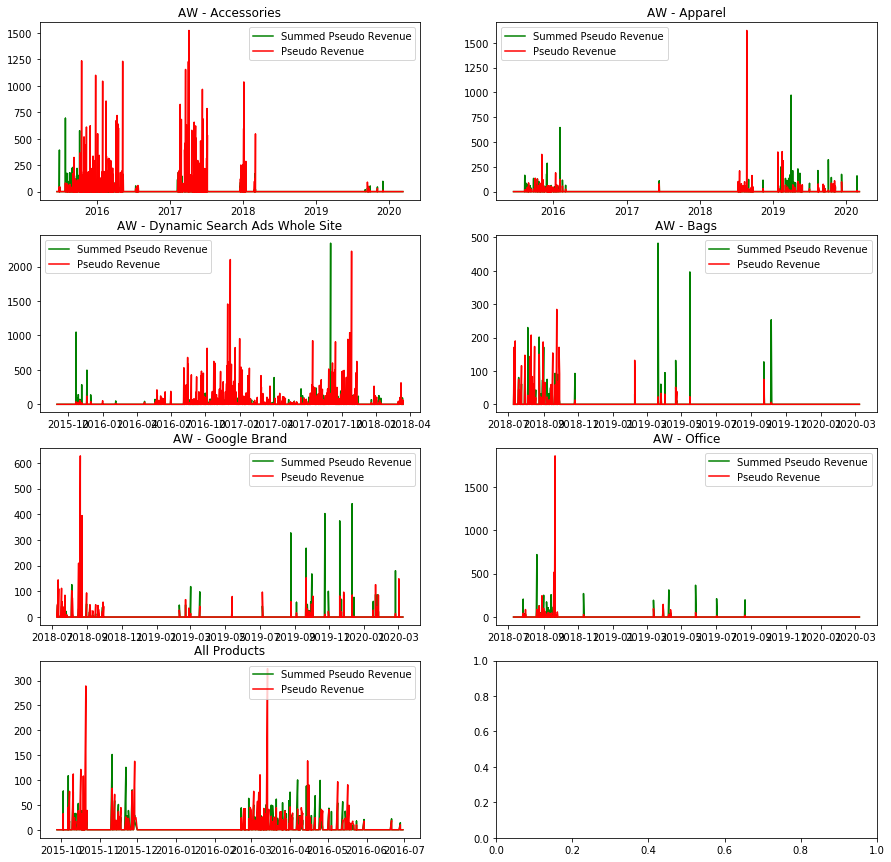

In [88]:
plotSummedRevenues(LRFinalDf)

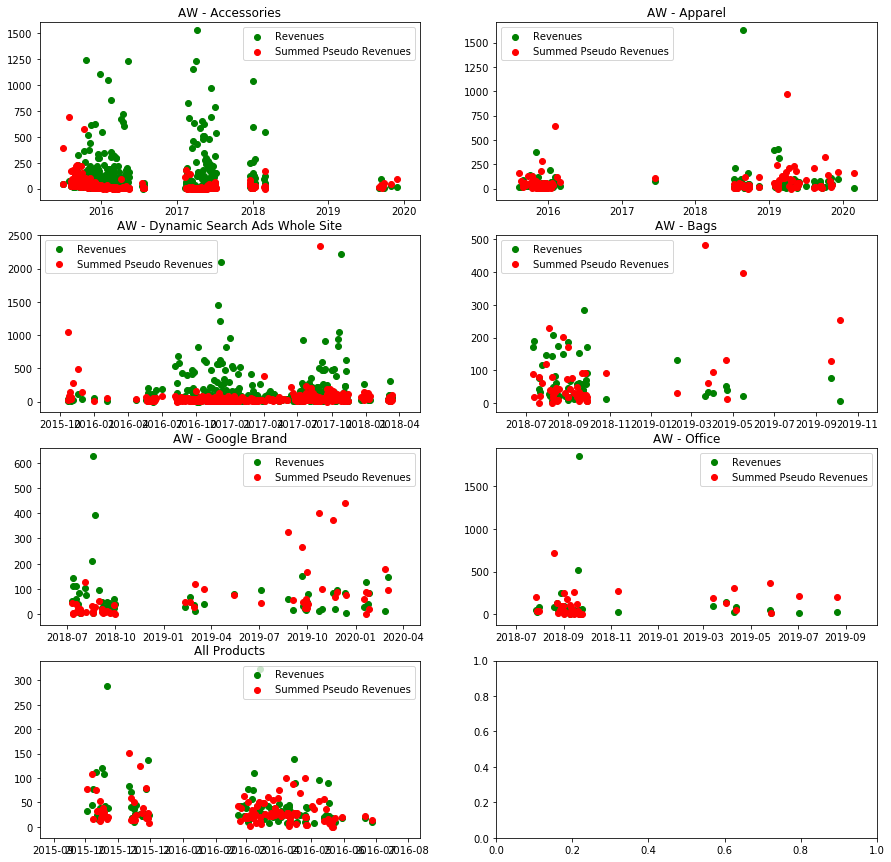

In [89]:
scatterSummedRevenues(LRFinalDf)

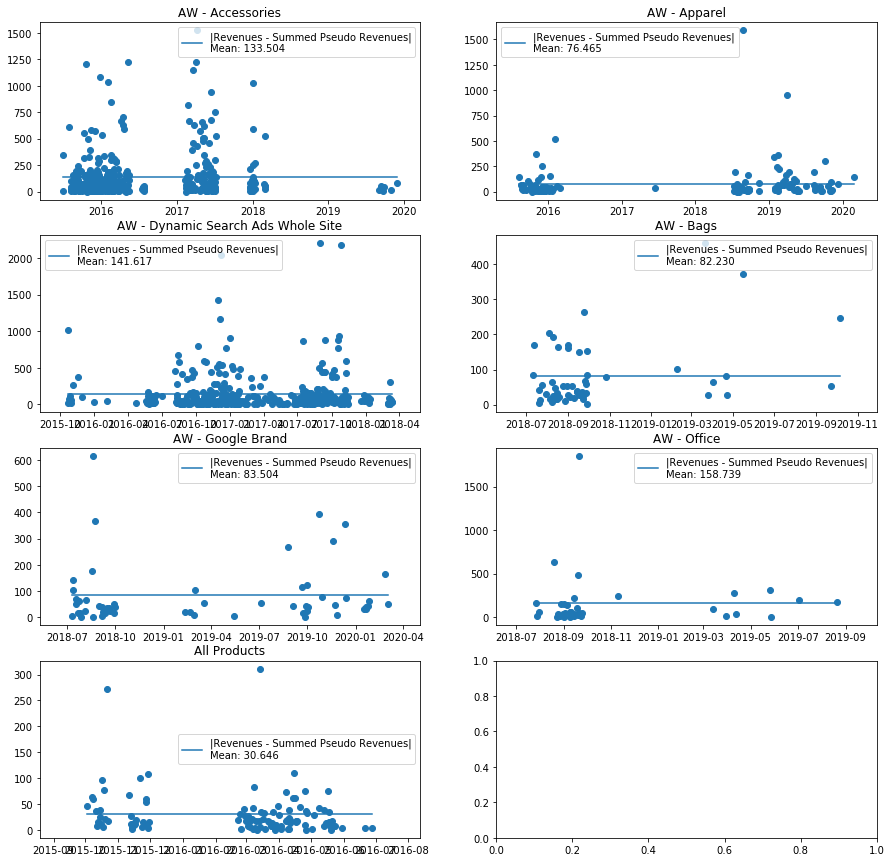

In [93]:
scatterErrorSummedRevenues(LRFinalDf)

In [99]:
LROverallError = getOverallError(LRFinalDf)
display(LROverallError)

,Campaign,Sum Revenues,Sum Pseudo Revenues,Avg Revenue,Avg Diff Error (L1),Avg Relative (%)
0,AW - Accessories,63700.71,4719.436513,140.930774,133.504 +/- 208.924,48.646934
1,AW - Apparel,9104.17,723.670683,65.972246,76.465 +/- 171.431,53.683411
2,AW - Bags,3721.28,482.759647,71.563077,82.230 +/- 94.144,53.467902
3,AW - Dynamic Search Ads Whole Site,57540.27,6404.421196,150.628979,141.617 +/- 265.229,48.458098
4,AW - Google Brand,4122.77,338.144580,73.620893,83.504 +/- 117.513,53.145076
5,AW - Office,4269.28,491.083729,118.591111,158.739 +/- 322.612,57.238291
6,All Products,4502.51,1314.651219,41.307431,30.646 +/- 43.937,42.591764


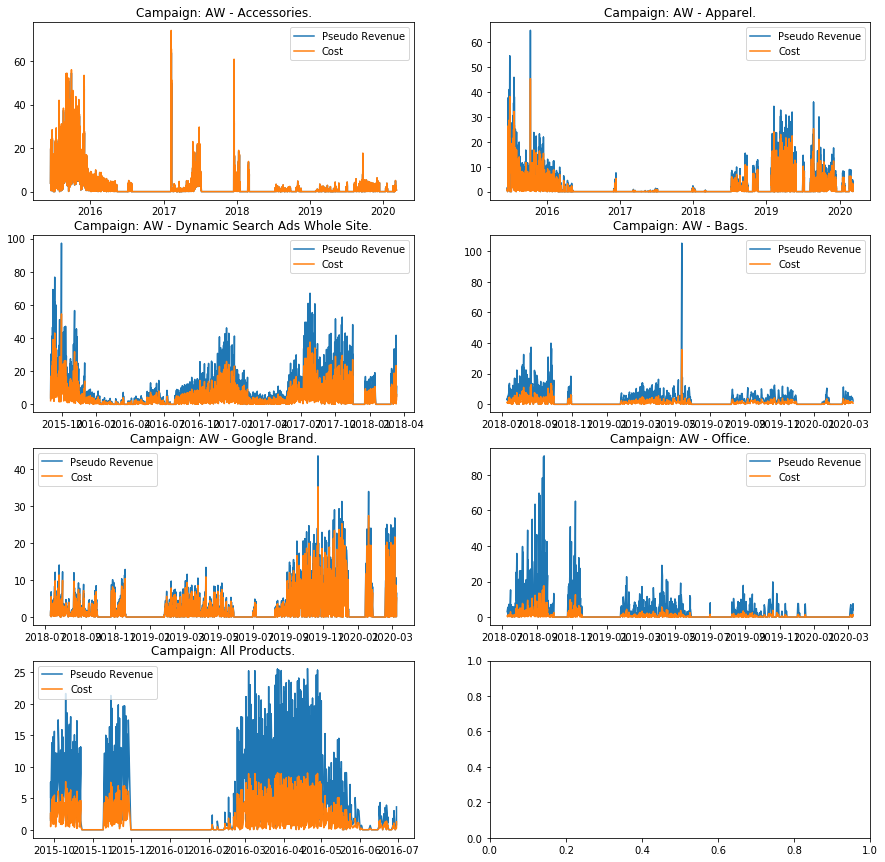

In [92]:
plotFinalResults(LRFinalDf, LROverallError)

### 2.4 Linear regression with more features